In [14]:
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split as tts

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler as SS

In [12]:
#adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [13]:
#start here
titanic = pd.read_csv('titanic_mod.csv')
titanic.head()

,pclass,sex,embarked,age,sibsp,parch,fare,survived
0,0.0,0.0,2.0,29.0000,0.0,0.0,211.3375,Yes
1,0.0,1.0,2.0,0.9167,1.0,2.0,151.5500,Yes
2,0.0,0.0,2.0,2.0000,1.0,2.0,151.5500,No
3,0.0,1.0,2.0,30.0000,1.0,2.0,151.5500,No
4,0.0,0.0,2.0,25.0000,1.0,2.0,151.5500,No


In [6]:
X_df = titanic.drop(columns = ['survived'])
X = np.array(X_df)
X_names = X_df.columns
y = titanic['survived'].values

In [7]:
X_df.head()

,pclass,sex,embarked,age,sibsp,parch,fare
0,0.0,0.0,2.0,29.0000,0.0,0.0,211.3375
1,0.0,1.0,2.0,0.9167,1.0,2.0,151.5500
2,0.0,0.0,2.0,2.0000,1.0,2.0,151.5500
3,0.0,1.0,2.0,30.0000,1.0,2.0,151.5500
4,0.0,0.0,2.0,25.0000,1.0,2.0,151.5500


In [8]:
X_df['pclass'].unique()

array([0., 1., 2.])

 ## Looking at PCA

In [32]:
pd.Series(X.std(axis = 0)/X.mean(axis = 0), X_df.columns).sort_values(ascending = False)

parch       2.245136
sibsp       2.085343
fare        1.556897
sex         0.741900
pclass      0.645112
embarked    0.545519
age         0.430664
dtype: float64

In [33]:
#unsup
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
pca = PCA(n_components = 2)
ss = SS()
pca_X = pca.fit_transform(ss.fit_transform(X))

In [34]:
print(pca.explained_variance_ratio_)

[0.27359922 0.23369135]


In [35]:
pd.DataFrame(pca.components_.T, index = X_names).sort_values(0,ascending = False, key = abs)

,0,1
fare,0.602424,0.099979
pclass,-0.580971,0.201412
embarked,-0.314992,0.122993
age,0.309307,-0.421925
sex,-0.262089,-0.305951
parch,0.170823,0.576316
sibsp,0.082440,0.574928


In [36]:
pd.DataFrame(pca.components_.T, index = X_names).sort_values(1,ascending = False, key = abs)

,0,1
parch,0.170823,0.576316
sibsp,0.082440,0.574928
age,0.309307,-0.421925
sex,-0.262089,-0.305951
pclass,-0.580971,0.201412
embarked,-0.314992,0.122993
fare,0.602424,0.099979


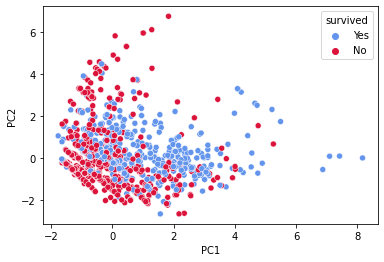

In [37]:
colors = ['violet','slategrey','forestgreen']
pca_df = pd.DataFrame(pca_X[:,:2], columns = ['PC1','PC2'])
pca_df['survived'] = y
ax = sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2',hue = 'survived', palette = ['cornflowerblue','crimson'])
plt.show()

## Feature selection with RF

In [38]:
#And yes, the results will change based on random state and test_size
Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size = 0.25, shuffle = True, random_state = 201, stratify = y)

In [282]:
#cross-validation with GridSearch for the RF
#first optimize the RF for the data

In [283]:
param_grid = dict(n_estimators=[100,500],
                 min_samples_split = [5,6,7,8,9,10]) #params to test
#cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cv = KFold(n_splits=10, random_state = 201, shuffle = True)
grid = GridSearchCV(RFC(random_state = 201), param_grid=param_grid, cv=cv, 
                    scoring='accuracy')
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=10, random_state=201, shuffle=True),
             estimator=RandomForestClassifier(random_state=201),
             param_grid={'min_samples_split': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 500]},
             scoring='accuracy')

In [284]:
print(
    f'The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}'
)

The best parameters are {'min_samples_split': 8, 'n_estimators': 100} with a score of 0.81


In [39]:
pd.DataFrame(grid.cv_results_)[['param_n_estimators',
                                'param_min_samples_split','mean_test_score','rank_test_score']]

NameError: name 'grid' is not defined

In [40]:
rfc = RFC(n_estimators = 100, min_samples_split = 8)

In [41]:
rfc.fit(Xtrain,ytrain)

RandomForestClassifier(min_samples_split=8)

In [42]:
rfc.score(Xtrain, ytrain)

0.9122448979591836

In [43]:
rfc.score(Xtest, ytest)

0.7737003058103975

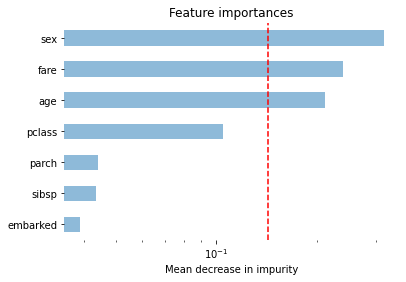

In [44]:
forest_importances = pd.Series(rfc.feature_importances_,  X_names)
filtered = forest_importances[forest_importances > 0].sort_values()[-15:]
fig, ax = plt.subplots()
filtered.plot.barh(ax=ax, alpha = 0.5)
plt.xscale('log')
plt.axvline(forest_importances.mean(), c = 'r',linestyle = '--' )
ax.set_title('Feature importances')
ax.set_xlabel('Mean decrease in impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.show()

In [295]:
xtrain_df = pd.DataFrame(Xtrain, columns = X_names)
ser = pd.Series()
for col in xtrain_df.columns:
    ser.loc[col] = len(xtrain_df[col].unique())
print(ser.sort_values(ascending = False))

fare        257
age          96
parch         8
sibsp         7
pclass        3
embarked      3
sex           2
dtype: int64


/var/folders/81/htmhjf795n5c2nkctv78dgj00000gp/T/ipykernel_26343/3239188901.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ser = pd.Series()


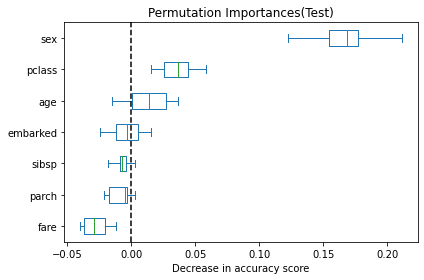

In [45]:
#Permutation
#from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rfc, Xtest,ytest, n_repeats=10, random_state=146, n_jobs=2
)
X_test_df = pd.DataFrame(Xtest, columns = X_names)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test_df.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances(Test)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

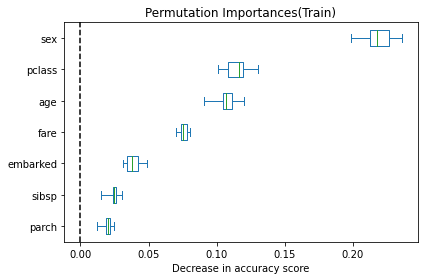

In [298]:
#Permutation
#from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rfc, Xtrain,ytrain, n_repeats=10, random_state=146, n_jobs=2
)
X_df = pd.DataFrame(Xtrain, columns = X_names)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_df.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances(Train)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Another example with more predictors

In [301]:
data = pd.read_csv('data/data_recode.txt', sep = ' ')
data = data.fillna(-1)
pheno = data['PHENOTYPE']

In [302]:
data2 = data.drop(columns = ['FID','IID','PAT','MAT','SEX','PHENOTYPE'])

In [303]:
y = pheno.values
X = data2.values

In [304]:
X.shape

(197, 166)

In [305]:
Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size = 0.2, shuffle = True, random_state = 42)

In [306]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42) 
rfc.fit(Xtrain, ytrain)

RandomForestClassifier(random_state=42)

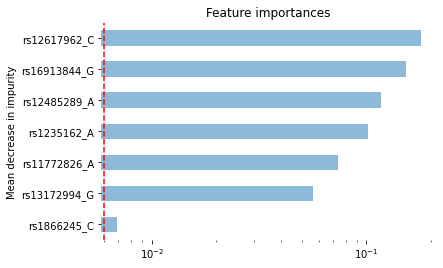

In [307]:
#Plot feature importances for features above the mean decrease in impurity
forest_importances = pd.Series(rfc.feature_importances_, data2.columns)
filtered = forest_importances[forest_importances > 
                             forest_importances.mean()].sort_values()[:15]
fig, ax = plt.subplots()
filtered.plot.barh(ax=ax, alpha = 0.5)
plt.xscale('log')
plt.axvline(forest_importances.mean(), c = 'r',linestyle = '--' )
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.show()

In [308]:
k = 10
kf = KFold(n_splits=k,shuffle=True,random_state=42)
rfc = RandomForestClassifier(max_features = 0.4, n_estimators=500,
                            min_samples_split = 3, random_state=42) 
feature_sel = []

for idxTrain, idxTest in kf.split(Xtrain):
    Xtrain2 = X[idxTrain,:]
    ytrain2 = y[idxTrain]
    rfc.fit(Xtrain2, ytrain2)
    forest_importances = pd.Series(rfc.feature_importances_, data2.columns)
    filtered = forest_importances[forest_importances > 
                             forest_importances.mean()].sort_values()[-15:]
    feature_sel.extend(list(filtered.index))
        

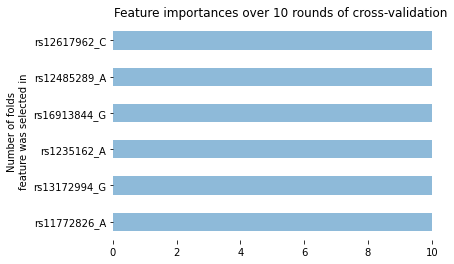

In [311]:
#Make a plot to summarize feature selection over the 10 runs of cv
#This means over all 10 runs of cv, how many times did each feature appear
#Plot that
feature_counts = {item:feature_sel.count(item) for item in feature_sel}
forest_importances = pd.Series(feature_counts)
forest_importances = forest_importances[forest_importances > 0]
fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax, alpha = 0.5)
ax.set_title('Feature importances over 10 rounds of cross-validation')
ax.set_ylabel('Number of folds\nfeature was selected in')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.show()